<a href="https://colab.research.google.com/github/hitergszf/fast.ai.deeplearning/blob/master/Lesson1_pets" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1_pets

# What's your pet 

# 你的宠物是什么

每一个notebook都由下面三行开始；它们确保你对库代码进行任何编辑，这些代码都将自动重新加载，并且任何图表或图片能在notebook中展示。

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

如果你的计算机GPU内存非常小，在运行notebook时，你很可能会碰到内存溢出的错误。如果这种情况发生了，点击Kernel->Restart，然后去除对下面第2行的注释，使用更小的*batch size*（批次大小，你将在课程中全面了解其含义），然后再试着运行一下。

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data 浏览一下数据

我们将使用由 [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)引用的[Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)数据集，这个数据集中有12个品种的猫和25个品种的狗。我们的模型需要学会正确区分这37个品种。根据上述学者的论文描述，他们能取得的最佳分类准确率是59.21%。这个结果是基于一个专门检测宠物品种的复杂模型得到的，这个模型对宠物的照片分别建立了“肖像”、“头部”以及“躯干”的独立模型。让我们来看看，使用深度学习能够达到什么样的准确率吧!

我们将通过引用一个URL参数来调用`untar_data`函数，这样就可以下载和解压相应数据。

In [0]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [0]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

当我们解决特定问题时，首先要做的是浏览一下数据。在想清楚最终如何解决一个问题之前，我们 *总是* 要深入理解问题和数据究竟意味着什么。浏览一下数据，意味着理解数据的内容和结构，分类标签是什么，样本图片是什么样的。

图片分类数据处理方式的最主要区别是标签存储方式。在这个数据集中，标签本身就存在于文件名之中。我们需要将标签信息提取出来，从而将这些图片分门别类。幸运的是，fastai库提供了一个非常好用的函数来实现这一点，`ImageDataBunch.from_name_re`函数通过使用[正则表达式](https://docs.python.org/3.6/library/re.html) 从文件名中提取标签信息。**(我们可以看出来，文件名中就是有这个图片的标签。所以可以根据这个来构造标签)**

In [0]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/samoyed_61.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/beagle_113.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_195.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_146.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_84.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

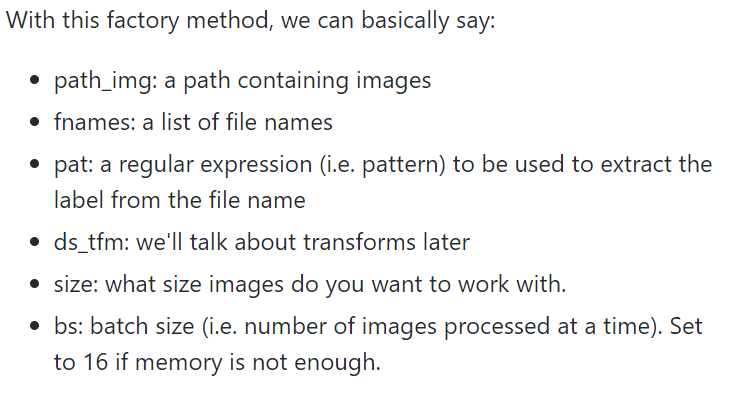

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

1. ds_tfm是一个特征转换，我们之后会涉及。其中一个比较重要的功能就是把所有的大小都变成224*224
2. 至于图片的size，我们一般设置为224*224，愿意简单来说就是便于我们的GPU处理
3. ImageDataBunch将会返回一个DataBunch的对象。这个DataBunch在fastai中是一个非常重要的概念。它包含了train，validation，（test） set。ImageDataBunch可以说一个DataBunch的子类，专用于计算机视觉的图像。

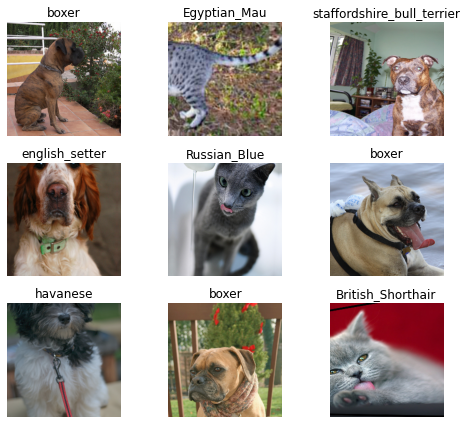

In [0]:
data.show_batch(rows=3, figsize=(7,6))

我们通过data.show_batch可以看到数据集中的图像

In [0]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

需要注意的是，DataBunch中会有一个属性c，这个属性在分类问题中就是classes，但是在回归问题中并非如此。具体的定义之后会了解

## Training: resnet34    

## 训练：resnet34

现在我们将要开始训练模型了。我们将使用一个 [卷积神经网络](http://cs231n.github.io/convolutional-networks/) 作为主干结构，衔接一个单隐藏层的全连接头部，构成分类器模型。
在fastai中，我们主要通过3个东西来训练：
- **DataBunch**: A general fastai concept for your data, and from there, there are subclasses for particular applications like **ImageDataBunch**
- **Learner**: A general concept for things that can learn to fit a model. From that, there are various subclasses to make things easier in particular, there is a convnet learner (something that will create a convolutional neural network for you).
- **architecture**：我们需要使用什么模型架构？看下一个cell

一般来说，ResNet的效果都是非常好的，所以我们一般都喜欢用resnet34或者resnet50作为**architecture**。我们先用参数少一些的resnet34架构来训练模型

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
help(cnn_learner)

Help on function cnn_learner in module fastai.vision.learner:

cnn_learner(data:fastai.basic_data.DataBunch, base_arch:Callable, cut:Union[int, Callable]=None, pretrained:bool=True, lin_ftrs:Union[Collection[int], NoneType]=None, ps:Union[float, Collection[float]]=0.5, custom_head:Union[torch.nn.modules.module.Module, NoneType]=None, split_on:Union[Callable, Collection[Collection[torch.nn.modules.module.Module]], NoneType]=None, bn_final:bool=False, init=<function kaiming_normal_ at 0x7faf3f2b5e18>, concat_pool:bool=True, **kwargs:Any) -> fastai.basic_train.Learner
    Build convnet style learner.



第一次运行上面的cell的时候，会下载一个resnet34的预训练模型，这个模型会作为初始权重。它源自于imagenet——它已经看过数以万计的图片了，所以我们就不需要从头造轮子——我们把这个叫做**Transfer Learning**

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.409175,0.321662,0.104871,01:26
1,0.606541,0.338160,0.104871,01:25
2,0.371082,0.243615,0.074425,01:25
3,0.266538,0.247638,0.074425,01:26


In [0]:
help(fit_one_cycle)

Help on function fit_one_cycle in module fastai.train:

fit_one_cycle(learn:fastai.basic_train.Learner, cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Tuple[float, float]=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, wd:float=None, callbacks:Union[Collection[fastai.callback.Callback], NoneType]=None, tot_epochs:int=None, start_epoch:int=None) -> None
    Fit a model following the 1cycle policy.



我们这里使用的fit方法叫做`fit_one_cycle`，这个和我们通常在pytorch和tensorflow上用的fit有所不同，2019年四月左右的论文中提出了这个方法，它比简单的fit有着更加优越的效果。

In [0]:
learn.save('stage-1')

这里我们训练之后希望能够保存一个模型的子目录在这个数据源的相同位置。因此如果需要保存不同的模型或者同一个模型的不同参数，最好要分开保存。

## Results 结果

让我们来看看结果如何。我们调用`ClassificationInterpretation`来显示解释分类的效果。



In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

我们首先看到的是模型最混淆的品种。我们要试着思考一下，模型预测的是否合理。在这个案例里，模型的错误分类看起来是合理的（没有犯明显的低级错误）。这意味着我们的分类器做的不错。

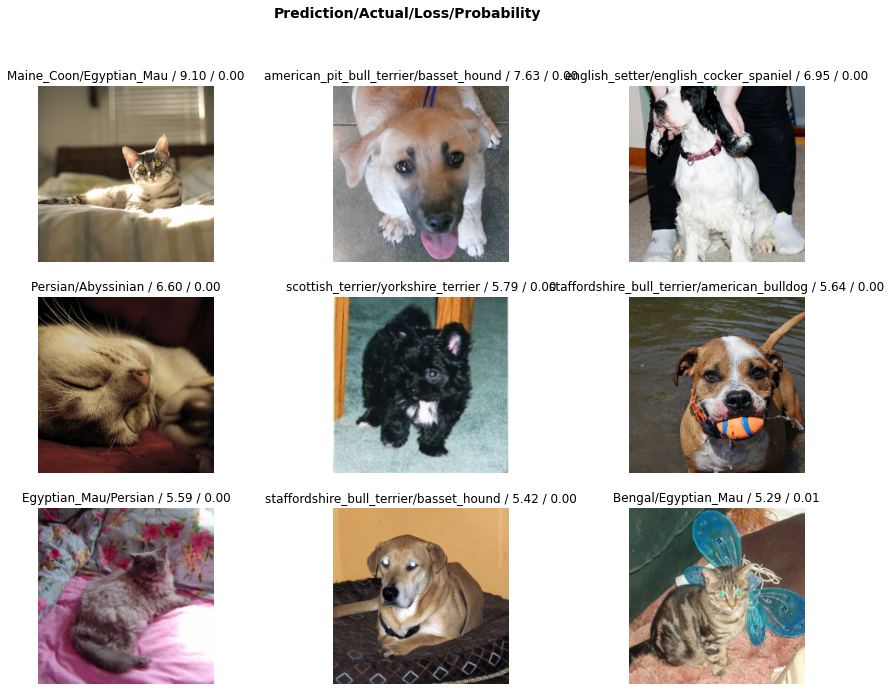

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

当我们绘制出（识别品种）的混淆矩阵时，我们可以看到数据分布是偏态的：模型会不断地重复相同的错误，但是很少会混淆其他品种。这意味着模型难以正确区分一些具体的品种；这是正常表现。

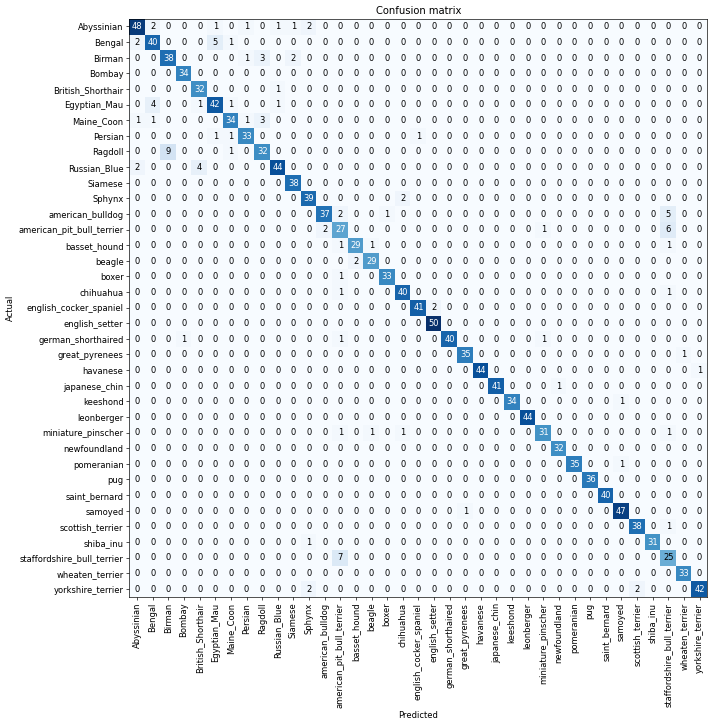

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 9),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('american_bulldog', 'staffordshire_bull_terrier', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('Birman', 'Ragdoll', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('Abyssinian', 'Bengal', 2),
 ('Abyssinian', 'Sphynx', 2),
 ('Bengal', 'Abyssinian', 2),
 ('Birman', 'Siamese', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('beagle', 'basset_hound', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('yorkshire_terrier', 'Sphynx', 2),
 ('yorkshire_terrier', 'scottish_terrier', 2)]

我们可以打印出最容易混淆的品种。举个例子来说，以第一个为例：
- 正确的：'Ragdoll', 
- 误分类的：'Birman', 
- 错了几次： 9

## 解冻，调优和学习率

既然我们的模型表现符合我们的预期，我们将*解冻* 模型并继续训练。

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.714337,0.396989,0.124493,01:30


效果不如以前，爬！
我们恢复之前的模型

In [0]:
learn.load('stage-1');

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


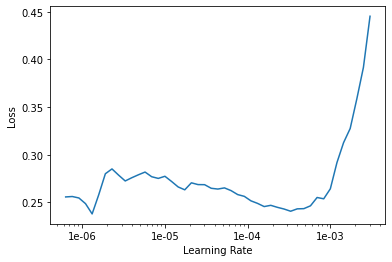

In [0]:
learn.recorder.plot()

这里我们使用`lr_find`去寻找学习率，`learn.recorder.plot()`可以帮助我们可视化这个过程。具体我们怎么选择我们的学习率我们可以在之后的课程中学到。我们找到第一个下降的点（其实在我们现在的这个图里面是2e-4左右，之前是1e-4所以下面给的是1e-4）我们把它作为上限。然后我们把1e-6作为下限。

这里我们传递的是一个slice！它可以让我们的学习率在变动中有上下限，具体的之后会学习到

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.256274,0.229797,0.075101,01:31
1,0.214262,0.223204,0.069012,01:29


## 训练:resnet50

现在我们将用和之前一样的方式训练模型，但是有一点需要提醒：这次我们将不再使用resnet34作为我们的主干结构，而是使用resnet50。（resnet34是一个34层的残差网络，而resnet50则有50层。本课程后续还会解释，你也可以通过研读[resnet残差网络论文](https://arxiv.org/pdf/1512.03385.pdf)来学习更多的细节）。

通常情况下，resnet50会表现出更好的性能，因为它是一个参数更多、层次更深的网络。我们来看看是否可以获得更好的成绩。为了帮助模型学习，我们使用更大尺寸的图片，这样就会让我们的网络看到更多细节特征。我们稍稍降低batch size，否则这个更大的网络会需要更多的GPU内存（以至于无法使用）。

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


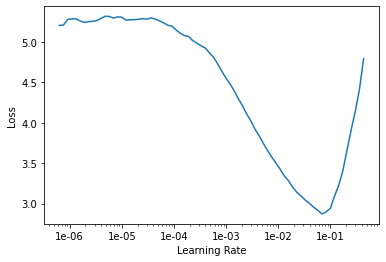

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.759684,0.311541,0.098782,02:23
1,0.541476,0.303667,0.085250,02:21
2,0.398094,0.337634,0.091340,02:20
3,0.336347,0.227123,0.063599,02:20
4,0.258022,0.203900,0.057510,02:20
5,0.172300,0.202833,0.056834,02:21
6,0.135085,0.171633,0.050744,02:20
7,0.108922,0.181790,0.050068,02:19


In [0]:
learn.save('stage-1-50')

真是不可思议，模型的宠物品种识别准确率如此之高！我们来看看能否再做一些有帮助的调优：

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.112435,0.179516,0.047361,02:42
1,0.105679,0.162679,0.052774,02:40
2,0.083624,0.162125,0.047361,02:41


就算调优没有帮助，你也总是能够回退到之前的模型。

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Birman', 'Siamese', 3),
 ('Persian', 'Ragdoll', 3),
 ('basset_hound', 'beagle', 3),
 ('boxer', 'american_bulldog', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('beagle', 'basset_hound', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('leonberger', 'keeshond', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

## Other data formats 

## 其他的数据格式

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/root/.fastai/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False) # 我们不希望它翻转。
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

In [0]:
doc(get_transforms)

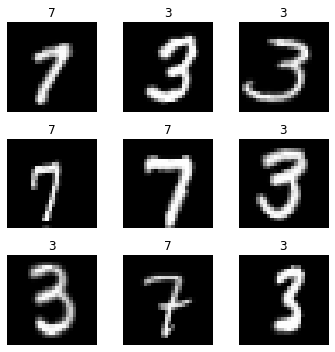

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.190530,0.080896,0.974975,00:16
1,0.120164,0.070561,0.974485,00:16


In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

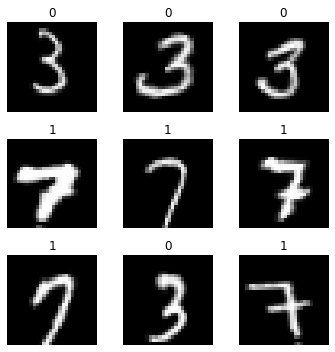

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']